In [2]:
import pyphs as phs
import sympy as sy
import numpy as np
import os

import datetime
import pickle
import sympy as sy
import matplotlib.pyplot as plt
import h5py
sy.init_printing()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

PPTY_PHY_PARAMS = {"positive": True, "real" : True }                            
PPTY_STATE_VAR  = {"real" : True }

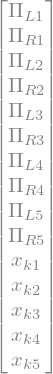

In [3]:
Ns = 5  # Number of subsystems
Ne = 3 # N of state per subsys
N_lambda = Ns-1 # constraints
Nx = Ns * Ne     # total N of states
Nx

piL_vec  = sy.symbols('Pi_L1:{}'.format(Ns+1), **PPTY_STATE_VAR)
piR_vec  = sy.symbols('Pi_R1:{}'.format(Ns+1), **PPTY_STATE_VAR)
xk_vec   = sy.symbols('x_k1:{}'.format(Ns+1), **PPTY_STATE_VAR)

mL_vec   = sy.symbols('m_L1:{}'.format(Ns+1), **PPTY_PHY_PARAMS)
mR_vec   = sy.symbols('m_R1:{}'.format(Ns+1), **PPTY_PHY_PARAMS)
k_vec    = sy.symbols('k_1:{}'.format(Ns+1), **PPTY_PHY_PARAMS)


X = []
for i in range(Ns):
    X.append(piL_vec[i])
    X.append(piR_vec[i])
X += list(xk_vec)
X = sy.Matrix(X)
X

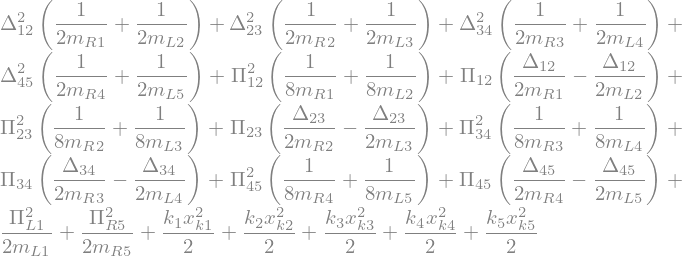

In [5]:
bT = sy.zeros(N_lambda, Nx)
for i in range(N_lambda):
    bT[i, 1+2*i] = 1 
    bT[i, 2+i*2] = -1
b = bT.T

annul_b = sy.zeros(Nx-N_lambda,Nx)

annul_b[0,0] = 1
annul_b[Ns::, Ns + N_lambda::] = sy.eye(Ns+1)
for i in range(1,N_lambda+1):
    annul_b[i, 2*i-1] = 1 
    annul_b[i, 2*i] = 1

M = sy.zeros(Nx, Nx)
M[0:Nx-N_lambda,::] = annul_b
M[Nx-N_lambda::, ::] = (bT*b).inv()*bT

Z = M*X
for i in range(N_lambda):
    Z[i+1] = sy.symbols('Pi_{0}{1}'.format(i+1,i+2), **PPTY_STATE_VAR)
for i in range(N_lambda):
    Z[Nx-N_lambda+i] = sy.symbols('Delta_{}'.format(10*(i+1) + (i+2)))
Z.T

# We are in a linear configuration for now
Q = sy.zeros(Nx)
for i in range(Ns):
    Q[2*i, 2*i] = 1/mL_vec[i]
    Q[2*i+1, 2*i+1] = 1/mR_vec[i]
    Q[i + 2*Ns, i + 2*Ns] = k_vec[i]
HX = sy.Rational(1,2) * X.T * Q * X
HX[0]

Minv = M.inv()
QZ = Minv.T * Q * Minv
QZ

HZ = sy.Rational(1,2) * Z.T * QZ * Z
HZ = HZ[0].expand().collect(Z)
HZ

'Find'

'such as: '

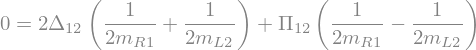

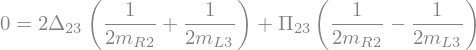

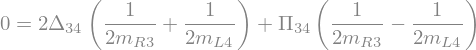

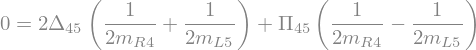

In [6]:
cstr_states = Z[Nx-N_lambda::]

cstr_eq = []
display("Find", cstr_states, "such as: ")
for i in range(N_lambda):
    cstr_eq.append(sy.Eq(0, HZ.diff(cstr_states[i])))
    display(cstr_eq[i])